## Assignment 3

#### Import Libraries

In [ ]:
import os
import pandas as pd
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import plotly.express as px
import plotly.graph_objects as go

warnings.simplefilter(action='ignore', category=FutureWarning)

#### Import Data / Data Preparation

In [2]:
def read_stations(year, month):
    station_path = os.path.join("stations", year, month)
    all_merged_data = []

    # Check if the station folder exists; if not, return an empty DataFrame
    if not os.path.exists(station_path):
        print(f"Station path {station_path} does not exist.")
        return pd.DataFrame()  # Return empty DataFrame if folder is missing

    # Iterate through all station files in the folder
    for station_file in os.listdir(station_path):
        if station_file.endswith(".csv"):
            station_data = pd.read_csv(os.path.join(station_path, station_file))

            # Filter for Dortmund stations and exclude unwanted stations
            station_data = station_data[
                (station_data['city'] == "Dortmund") &  # Only include stations in Dortmund
                (~station_data['name'].str.contains("BAB|BAT|Autobahntankstelle", case=False, na=False))  # Exclude highway stations
            ]

            # Extract the date from the station file name
            date_in_file = station_file.split(".")[0].replace("-stations", "")
            # Merge station data with price data for the specific date
            merged_data = read_prices(year, month, date_in_file, station_data)
            all_merged_data.append(merged_data)

    # Combine all merged data into a single DataFrame; return an empty DataFrame if no data is available
    return pd.concat(all_merged_data, ignore_index=True) if all_merged_data else pd.DataFrame()

def read_prices(year, month, date_in_file, station_df):
    price_path = os.path.join("prices", year, month)
    price_file = os.path.join(price_path, f"{date_in_file}-prices.csv")

    # Check if the price file exists; if not, return an empty DataFrame
    if not os.path.exists(price_file):
        print(f"Price file {price_file} does not exist.")
        return pd.DataFrame()  # Return empty DataFrame if file is missing

    # Read price data and convert the 'date' column to datetime
    price_data = pd.read_csv(price_file)
    price_data['date'] = pd.to_datetime(price_data['date'])

    # Merge price data with station data based on 'station_uuid'
    price_data = price_data[['date', 'station_uuid', 'e10', 'e10change']]
    merged_data = pd.merge(price_data, station_df, left_on='station_uuid', right_on='uuid', how='inner')

    # Logic: Keep only the first price and subsequent rows where 'e10change' is 1
    filtered_data = []
    for station_uuid, group in merged_data.groupby('station_uuid'):
        group = group.sort_values('date')  # Sort by date
        first_row = group.iloc[0].to_dict()  # First price as a dictionary
        filtered_data.append(first_row)

        group = group.iloc[1:]  # Skip the first row
        subsequent_rows = group[group['e10change'] == 1].to_dict('records')  # Rows where 'e10change' is 1
        filtered_data.extend(subsequent_rows)

    # Convert the list of dictionaries to a DataFrame
    filtered_data = pd.DataFrame(filtered_data)

    # Fill missing 'e10' prices
    for i in filtered_data.index[filtered_data['e10'] == 0]:
        current_date = filtered_data.at[i, 'date']
        station_uuid = filtered_data.at[i, 'station_uuid']

        print(f"Missing price on {current_date.strftime('%Y-%m-%d')} for station UUID {station_uuid}")
        price_previous_day = find_price_previous_day(current_date, station_uuid)

        # If a valid price from the previous day is found, use it
        if price_previous_day is not None:
            filtered_data.at[i, 'e10'] = price_previous_day['e10']
            print(f"Applied last valid price: {price_previous_day['e10']}")

    # Remove stations with missing prices (where 'e10' is still 0)
    before_removal = len(filtered_data)
    filtered_data = filtered_data[filtered_data['e10'] != 0]
    after_removal = len(filtered_data)
    
    print(f"Removed {before_removal - after_removal} stations with missing prices.")

    return filtered_data

def find_price_previous_day(current_date, station_uuid):
    # Calculate the previous day's date
    previous_day = current_date - timedelta(days=1)
    previous_price_file = os.path.join(
        "prices", str(previous_day.year), f"{previous_day.month:02d}",
        f"{previous_day.year}-{previous_day.month:02d}-{previous_day.day:02d}-prices.csv"
    )

    # Check if the previous day's price file exists
    if not os.path.exists(previous_price_file):
        print(f"Previous price file {previous_price_file} does not exist.")
        return None

    # Read the previous day's price data
    previous_price_data = pd.read_csv(previous_price_file)
    previous_price_data['date'] = pd.to_datetime(previous_price_data['date'])

    # Filter for the same station and a valid price
    previous_price = previous_price_data[
        (previous_price_data['station_uuid'] == station_uuid) &  # Same station
        (previous_price_data['e10'] != 0)  # Valid price
    ]

    # Return the most recent price for the station
    return previous_price.sort_values('date', ascending=False).iloc[0] if not previous_price.empty else None

result = []

for year in ["2023", "2024"]:
    months = ["11", "12"] if year == "2023" else [f"{i:02d}" for i in range(1, 11)]

    for month in months:
        # Read station and price data for the year and month
        price_data = read_stations(year, month)
        if not price_data.empty:
            result.append(price_data)

final_df = pd.concat(result, ignore_index=True) if result else pd.DataFrame()


Missing price on 2023-11-01 for station UUID 1188fc0b-9937-4442-90a3-fafe8bf6fb4f
Missing price on 2023-11-01 for station UUID 32e96f98-71b8-4387-ad90-4896c012a24e
Missing price on 2023-11-01 for station UUID 5d345174-40a9-4439-9757-ef0140101ebf
Missing price on 2023-11-01 for station UUID 5e170168-3c33-4f26-a3d2-4a312a41b825
Removed 4 stations with missing prices.
Missing price on 2023-11-02 for station UUID 1188fc0b-9937-4442-90a3-fafe8bf6fb4f
Missing price on 2023-11-02 for station UUID 32e96f98-71b8-4387-ad90-4896c012a24e
Missing price on 2023-11-02 for station UUID 5915ebc0-e19e-47b8-bfce-0fbb3234ab54
Missing price on 2023-11-02 for station UUID 5d345174-40a9-4439-9757-ef0140101ebf
Missing price on 2023-11-02 for station UUID 5e170168-3c33-4f26-a3d2-4a312a41b825
Removed 5 stations with missing prices.
Missing price on 2023-11-03 for station UUID 1188fc0b-9937-4442-90a3-fafe8bf6fb4f
Missing price on 2023-11-03 for station UUID 32e96f98-71b8-4387-ad90-4896c012a24e
Missing price on 2

C:\Users\Caroline Bastians\AppData\Local\Temp\ipykernel_3500\1210602000.py:41: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  price_data['date'] = pd.to_datetime(price_data['date'])


Missing price on 2024-03-31 for station UUID 1188fc0b-9937-4442-90a3-fafe8bf6fb4f
Missing price on 2024-03-31 for station UUID 32e96f98-71b8-4387-ad90-4896c012a24e
Missing price on 2024-03-31 for station UUID 5d345174-40a9-4439-9757-ef0140101ebf
Missing price on 2024-03-31 for station UUID 5e170168-3c33-4f26-a3d2-4a312a41b825
Removed 4 stations with missing prices.
Missing price on 2024-04-01 for station UUID 1188fc0b-9937-4442-90a3-fafe8bf6fb4f


C:\Users\Caroline Bastians\AppData\Local\Temp\ipykernel_3500\1210602000.py:98: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  previous_price_data['date'] = pd.to_datetime(previous_price_data['date'])


Missing price on 2024-04-01 for station UUID 32e96f98-71b8-4387-ad90-4896c012a24e


C:\Users\Caroline Bastians\AppData\Local\Temp\ipykernel_3500\1210602000.py:98: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  previous_price_data['date'] = pd.to_datetime(previous_price_data['date'])


Missing price on 2024-04-01 for station UUID 5915ebc0-e19e-47b8-bfce-0fbb3234ab54


C:\Users\Caroline Bastians\AppData\Local\Temp\ipykernel_3500\1210602000.py:98: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  previous_price_data['date'] = pd.to_datetime(previous_price_data['date'])


Missing price on 2024-04-01 for station UUID 5d345174-40a9-4439-9757-ef0140101ebf


C:\Users\Caroline Bastians\AppData\Local\Temp\ipykernel_3500\1210602000.py:98: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  previous_price_data['date'] = pd.to_datetime(previous_price_data['date'])


Missing price on 2024-04-01 for station UUID 5e170168-3c33-4f26-a3d2-4a312a41b825


C:\Users\Caroline Bastians\AppData\Local\Temp\ipykernel_3500\1210602000.py:98: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  previous_price_data['date'] = pd.to_datetime(previous_price_data['date'])


Removed 5 stations with missing prices.
Missing price on 2024-04-02 for station UUID 1188fc0b-9937-4442-90a3-fafe8bf6fb4f
Missing price on 2024-04-02 for station UUID 32e96f98-71b8-4387-ad90-4896c012a24e
Missing price on 2024-04-02 for station UUID 5915ebc0-e19e-47b8-bfce-0fbb3234ab54
Missing price on 2024-04-02 for station UUID 5d345174-40a9-4439-9757-ef0140101ebf
Missing price on 2024-04-02 for station UUID 5e170168-3c33-4f26-a3d2-4a312a41b825
Removed 5 stations with missing prices.
Missing price on 2024-04-03 for station UUID 1188fc0b-9937-4442-90a3-fafe8bf6fb4f
Missing price on 2024-04-03 for station UUID 32e96f98-71b8-4387-ad90-4896c012a24e
Missing price on 2024-04-03 for station UUID 5915ebc0-e19e-47b8-bfce-0fbb3234ab54
Missing price on 2024-04-03 for station UUID 5d345174-40a9-4439-9757-ef0140101ebf
Missing price on 2024-04-03 for station UUID 5e170168-3c33-4f26-a3d2-4a312a41b825
Removed 5 stations with missing prices.
Missing price on 2024-04-04 for station UUID 1188fc0b-9937-4

C:\Users\Caroline Bastians\AppData\Local\Temp\ipykernel_3500\1210602000.py:41: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  price_data['date'] = pd.to_datetime(price_data['date'])


Missing price on 2024-10-27 for station UUID 1188fc0b-9937-4442-90a3-fafe8bf6fb4f
Missing price on 2024-10-27 for station UUID 27b7b18e-85a8-455d-863c-2f8dbdcf256d
Missing price on 2024-10-27 for station UUID 32e96f98-71b8-4387-ad90-4896c012a24e
Missing price on 2024-10-27 for station UUID 3eba12bf-7c1e-4b4a-a39f-2cb077115071
Missing price on 2024-10-27 for station UUID 5d345174-40a9-4439-9757-ef0140101ebf
Missing price on 2024-10-27 for station UUID 5e170168-3c33-4f26-a3d2-4a312a41b825
Removed 6 stations with missing prices.
Missing price on 2024-10-28 for station UUID 1188fc0b-9937-4442-90a3-fafe8bf6fb4f


C:\Users\Caroline Bastians\AppData\Local\Temp\ipykernel_3500\1210602000.py:98: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  previous_price_data['date'] = pd.to_datetime(previous_price_data['date'])


Missing price on 2024-10-28 for station UUID 27b7b18e-85a8-455d-863c-2f8dbdcf256d


C:\Users\Caroline Bastians\AppData\Local\Temp\ipykernel_3500\1210602000.py:98: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  previous_price_data['date'] = pd.to_datetime(previous_price_data['date'])


Missing price on 2024-10-28 for station UUID 32e96f98-71b8-4387-ad90-4896c012a24e


C:\Users\Caroline Bastians\AppData\Local\Temp\ipykernel_3500\1210602000.py:98: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  previous_price_data['date'] = pd.to_datetime(previous_price_data['date'])


Missing price on 2024-10-28 for station UUID 3eba12bf-7c1e-4b4a-a39f-2cb077115071


C:\Users\Caroline Bastians\AppData\Local\Temp\ipykernel_3500\1210602000.py:98: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  previous_price_data['date'] = pd.to_datetime(previous_price_data['date'])


Missing price on 2024-10-28 for station UUID 5d345174-40a9-4439-9757-ef0140101ebf


C:\Users\Caroline Bastians\AppData\Local\Temp\ipykernel_3500\1210602000.py:98: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  previous_price_data['date'] = pd.to_datetime(previous_price_data['date'])


Missing price on 2024-10-28 for station UUID 5e170168-3c33-4f26-a3d2-4a312a41b825


C:\Users\Caroline Bastians\AppData\Local\Temp\ipykernel_3500\1210602000.py:98: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  previous_price_data['date'] = pd.to_datetime(previous_price_data['date'])


Removed 6 stations with missing prices.
Missing price on 2024-10-29 for station UUID 1188fc0b-9937-4442-90a3-fafe8bf6fb4f
Missing price on 2024-10-29 for station UUID 27b7b18e-85a8-455d-863c-2f8dbdcf256d
Missing price on 2024-10-29 for station UUID 32e96f98-71b8-4387-ad90-4896c012a24e
Missing price on 2024-10-29 for station UUID 3eba12bf-7c1e-4b4a-a39f-2cb077115071
Missing price on 2024-10-29 for station UUID 5d345174-40a9-4439-9757-ef0140101ebf
Missing price on 2024-10-29 for station UUID 5e170168-3c33-4f26-a3d2-4a312a41b825
Removed 6 stations with missing prices.
Missing price on 2024-10-30 for station UUID 1188fc0b-9937-4442-90a3-fafe8bf6fb4f
Missing price on 2024-10-30 for station UUID 27b7b18e-85a8-455d-863c-2f8dbdcf256d
Missing price on 2024-10-30 for station UUID 32e96f98-71b8-4387-ad90-4896c012a24e
Missing price on 2024-10-30 for station UUID 3eba12bf-7c1e-4b4a-a39f-2cb077115071
Missing price on 2024-10-30 for station UUID 5d345174-40a9-4439-9757-ef0140101ebf
Missing price on 2

In [ ]:
final_df = final_df.drop(['uuid'], axis=1)
final_df['date'] = pd.to_datetime(final_df['date'], utc=True)
final_df['date'] = final_df['date'].dt.tz_localize(None)

final_df.head(5)

,date,station_uuid,e10,e10change,name,brand,street,house_number,post_code,city,latitude,longitude,first_active,openingtimes_json
0,2023-11-01 04:23:46+01:00,005056ba-7cb6-1ed2-bceb-57e186e40d16,1.749,1,star Tankstelle,STAR,Evinger Straße,517,44339,Dortmund,51.573735,7.464103,2014-03-18 16:45:31+01,"{""openingTimes"":[{""applicable_days"":31,""period..."
1,2023-11-01 05:13:47+01:00,005056ba-7cb6-1ed2-bceb-57e186e40d16,1.739,1,star Tankstelle,STAR,Evinger Straße,517,44339,Dortmund,51.573735,7.464103,2014-03-18 16:45:31+01,"{""openingTimes"":[{""applicable_days"":31,""period..."
2,2023-11-01 05:53:10+01:00,005056ba-7cb6-1ed2-bceb-57e186e40d16,1.769,1,star Tankstelle,STAR,Evinger Straße,517,44339,Dortmund,51.573735,7.464103,2014-03-18 16:45:31+01,"{""openingTimes"":[{""applicable_days"":31,""period..."
3,2023-11-01 06:53:38+01:00,005056ba-7cb6-1ed2-bceb-57e186e40d16,1.829,1,star Tankstelle,STAR,Evinger Straße,517,44339,Dortmund,51.573735,7.464103,2014-03-18 16:45:31+01,"{""openingTimes"":[{""applicable_days"":31,""period..."
4,2023-11-01 07:28:30+01:00,005056ba-7cb6-1ed2-bceb-57e186e40d16,1.819,1,star Tankstelle,STAR,Evinger Straße,517,44339,Dortmund,51.573735,7.464103,2014-03-18 16:45:31+01,"{""openingTimes"":[{""applicable_days"":31,""period..."


#### Price pattern per hour and per day. 

In [ ]:
final_df['hour'] = final_df['date'].dt.hour
final_df['day_of_week'] = final_df['date'].dt.day_name()

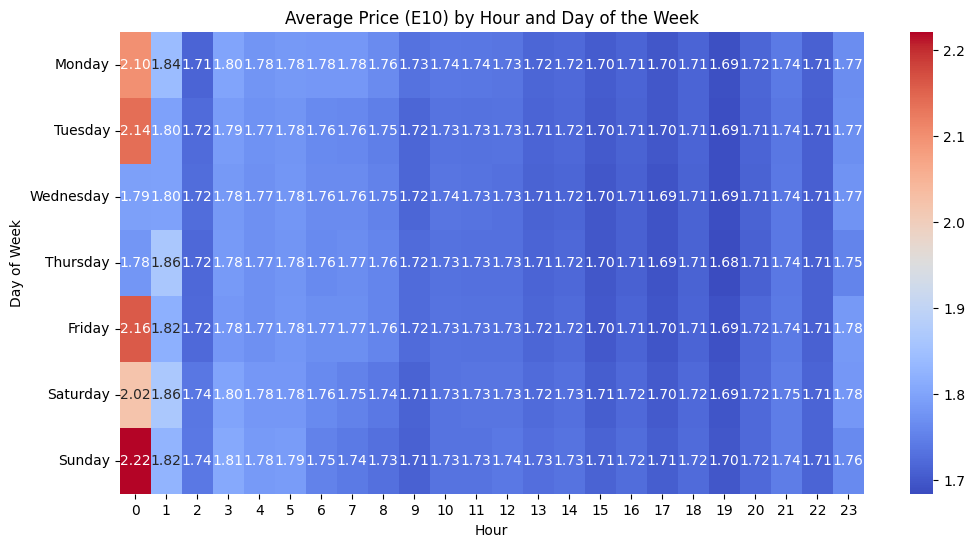

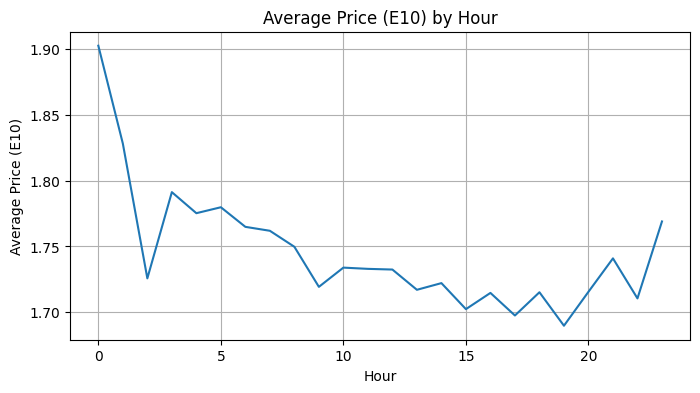

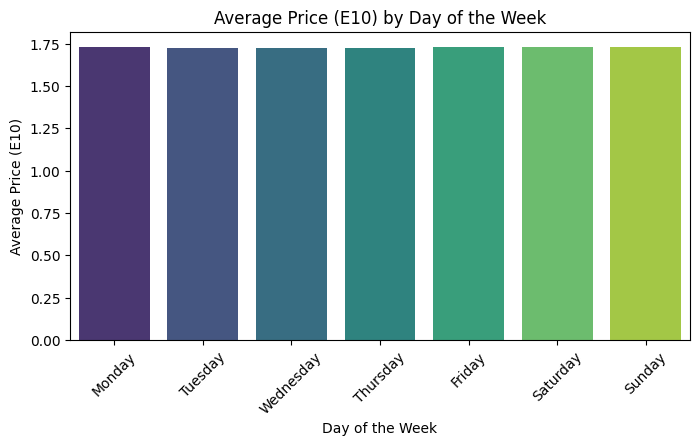

In [29]:
hourly_pattern = final_df.groupby('hour')['e10'].mean().reset_index()
daily_pattern = final_df.groupby('day_of_week')['e10'].mean().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)

heatmap_data = final_df.groupby(['day_of_week', 'hour'])['e10'].mean().unstack().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Average Price (E10) by Hour and Day of the Week")
plt.xlabel("Hour")
plt.ylabel("Day of Week")
plt.show()

plt.figure(figsize=(8, 4))
sns.lineplot(data=hourly_pattern, x='hour', y='e10')
plt.title("Average Price (E10) by Hour")
plt.xlabel("Hour")
plt.ylabel("Average Price (E10)")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 4))
sns.barplot(x=daily_pattern.index, y=daily_pattern.values, palette="viridis")
plt.title("Average Price (E10) by Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Average Price (E10)")
plt.xticks(rotation=45)
plt.show()


#### Price deviations per brand

                                 mean       std
brand                                          
Klink                        1.662969  0.044337
Calpam                       1.666225  0.038844
GO                           1.702266  0.049361
OIL!                         1.706580  0.068692
Q1                           1.707409  0.067284
STAR                         1.708207  0.068696
HEM                          1.708476  0.069320
T Xpress                     1.708884  0.072432
SB                           1.708912  0.068602
Tankstation Oespel (Calpam)  1.710893  0.071142
Markant (Tankautomat)        1.711586  0.068664
ORLEN                        1.712779  0.068762
Markant                      1.713573  0.067574
Classic Tankstelle           1.714309  0.071570
Bavaria Petrol               1.715838  0.069408
BFT                          1.718054  0.070202
BFT Tankstelle               1.720046  0.072188
Mr. Wash Autoservice AG      1.721239  0.067447
T                            1.721929  0

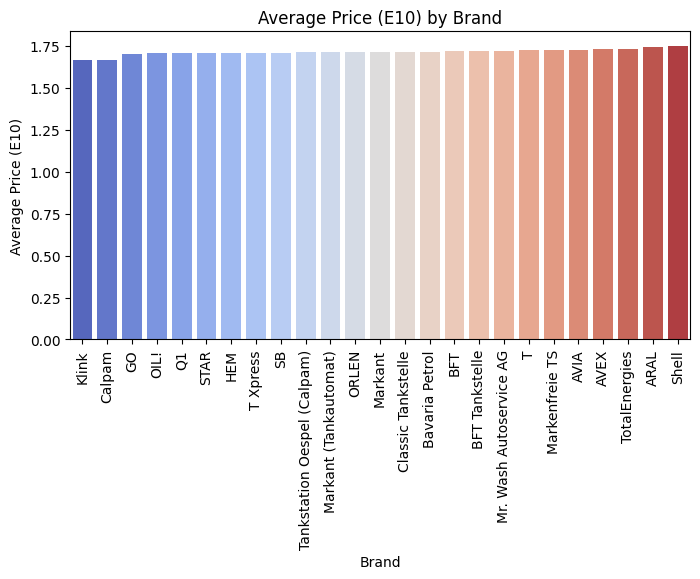

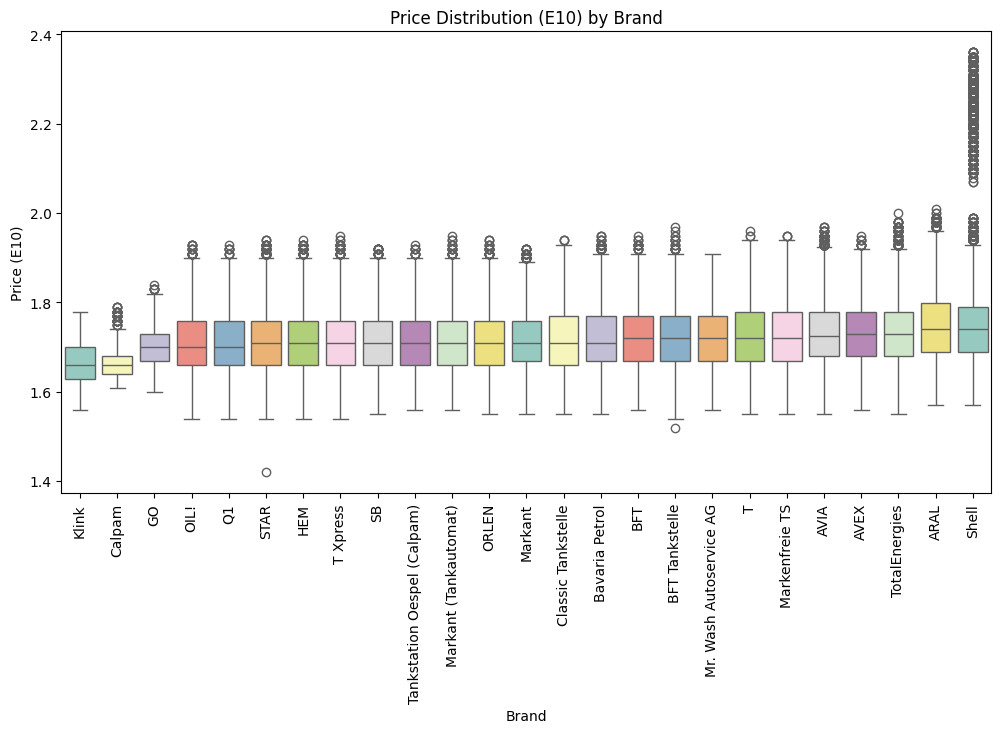

In [33]:
brand_stats = final_df.groupby('brand')['e10'].agg(['mean', 'std']).sort_values('mean', ascending=True)

print(brand_stats)

plt.figure(figsize=(8, 4))
sns.barplot(
    data=brand_stats.reset_index(),
    x='brand',
    y='mean',
    order=brand_stats.index, 
    palette="coolwarm"
)
plt.title("Average Price (E10) by Brand")
plt.xlabel("Brand")
plt.ylabel("Average Price (E10)")
plt.xticks(rotation=90) 
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(
    data=final_df,
    x='brand',
    y='e10',
    order=brand_stats.index, 
    palette="Set3"
)
plt.title("Price Distribution (E10) by Brand")
plt.xlabel("Brand")
plt.ylabel("Price (E10)")
plt.xticks(rotation=90)  
plt.show()